### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.constants import G, c
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [2]:
H_0   = cosmo.H0    # Hubble constant [km/s/Mpc]
c_si  = c.to(u.m/u.s)    # Speed of light [m/s]
G_si  = G.to(u.m**3/(u.kg*u.s**2))  # Gravitational constant [m³/(kg·s²)]
q0    = -0.534  # Deceleration parameter (Planck)
c_kms = c.to(u.km / u.s) # Speed of light [km/s]

In [3]:
print("H₀ =", H_0)
print("c  =", c_si)
print("G  =", G_si)
print("q₀ =", q0)

H₀ = 67.66 km / (Mpc s)
c  = 299792458.0 m / s
G  = 6.6743e-11 m3 / (kg s2)
q₀ = -0.534


Read the csv data into the python using the method below

In [4]:
csv_file = "Skyserver_SQL6_25_2025 12_02_01 PM.csv"
df = pd.read_csv(csv_file)

In [5]:
print("Columns:", df.columns.tolist())

Columns: ['objid', 'ra', 'dec', 'photoz', 'photozerr', 'specz', 'speczerr', 'proj_sep', 'umag', 'umagerr', 'gmag', 'gmagerr', 'rmag', 'rmagerr', 'obj_type']


In [6]:
df.head()

,objid,ra,dec,photoz,photozerr,specz,speczerr,proj_sep,umag,umagerr,gmag,gmagerr,rmag,rmagerr,obj_type
0,1237671768542478711,257.82458,64.133257,0.079193,0.022867,0.082447,0.000017,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3
1,1237671768542478711,257.82458,64.133257,0.079193,0.022867,0.082466,0.000014,8.347733,18.96488,0.043377,17.49815,0.005672,16.75003,0.004708,3
2,1237671768542478713,257.83332,64.126043,0.091507,0.014511,0.081218,0.000021,8.011259,20.22848,0.072019,18.38334,0.007763,17.46793,0.005828,3
3,1237671768542544090,257.85137,64.173247,0.081102,0.009898,0.079561,0.000022,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3
4,1237671768542544090,257.85137,64.173247,0.081102,0.009898,0.079568,0.000019,8.739276,19.21829,0.050135,17.18970,0.004936,16.22043,0.003769,3


### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [7]:
averaged_df = (
    df.groupby("objid")
      .agg({
          "specz":    "mean",   # average redshift
          "ra":       "first",  # keep sky position
          "dec":      "first",
          "proj_sep": "first",  # angular separation
          "rmag":     "mean"    # average r-band mag
      })
      .reset_index()
)

In [8]:
averaged_df.describe()['specz']

,specz
count,92.000000
mean,0.080838
std,0.008578
min,0.069976
25%,0.077224
50%,0.080961
75%,0.082797
max,0.150886


To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group.

Find the mean, standard deviation and limits of the redshift from the data

In [9]:
z_mean = averaged_df["specz"].mean()
z_std  = averaged_df["specz"].std(ddof=1)
z_min, z_max = z_mean - 3*z_std, z_mean + 3*z_std

print(f"Mean z = {z_mean:.5f}, σ_z = {z_std:.5f}")
print(f"3σ window: {z_min:.5f} to {z_max:.5f}")

Mean z = 0.08084, σ_z = 0.00858
3σ window: 0.05510 to 0.10657


You can also use boxplot to visualize the overall values of redshift

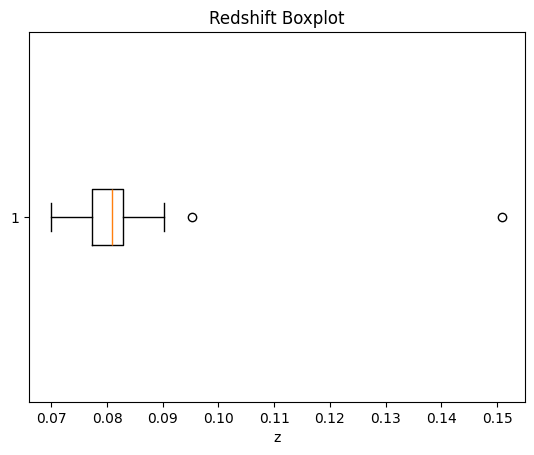

In [10]:
# visualize the redshift distribution
plt.figure();
plt.boxplot(averaged_df["specz"], vert=False)
plt.title("Redshift Boxplot");
plt.xlabel("z");
plt.show()

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

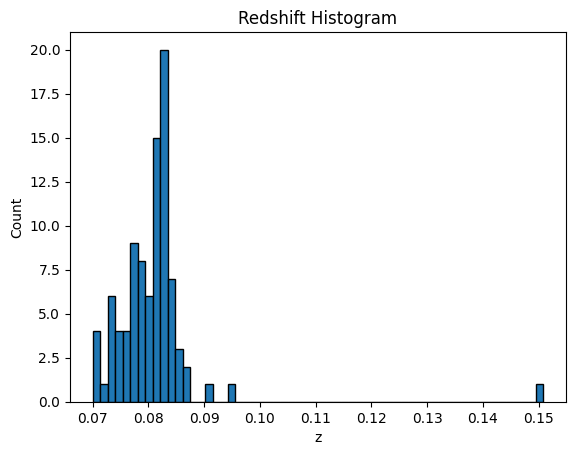

In [11]:
plt.figure();
plt.hist(averaged_df["specz"], bins=60, edgecolor="black")
plt.title("Redshift Histogram");
plt.xlabel("z");
plt.ylabel("Count");
plt.show();

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [12]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
cluster_df = averaged_df[(averaged_df["specz"] >= z_min) & (averaged_df["specz"] <= z_max)]
print(f"Found {len(cluster_df)} cluster members out of {len(averaged_df)}")

Found 91 cluster members out of 92


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift

In [13]:
cluster_df["velocity"] = (cluster_df["specz"].values * c_kms).to(u.km/u.s)

/tmp/ipython-input-13-869131744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["velocity"] = (cluster_df["specz"].values * c_kms).to(u.km/u.s)


use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

In [14]:
sigma_v_approx = np.std([v.value for v in cluster_df["velocity"]], ddof=1) * u.km/u.s
print("Approximate σᵥ =", sigma_v_approx)

Approximate σᵥ = 1316.152774680483 km / s


### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [16]:
filtered_df = averaged_df[(averaged_df["specz"] >= z_min) & (averaged_df["specz"] <= z_max)]
z_c   = filtered_df["specz"].mean()
z_arr = filtered_df["specz"].values

In [17]:
v_rel = (c_kms * ((1+z_arr)**2 - (1+z_c)**2) / ((1+z_arr)**2 + (1+z_c)**2)).to(u.km/u.s)
filtered_df["velocity_rel"] = v_rel
disp = np.std(v_rel.value, ddof=1) * u.km/u.s

/tmp/ipython-input-17-3673429257.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["velocity_rel"] = v_rel


In [18]:
print(f"Cluster mean redshift = {z_c:.5f}")
print("Velocity dispersion σᵥ =", disp)

Cluster mean redshift = 0.08007
Velocity dispersion σᵥ = 1218.4929446822505 km / s


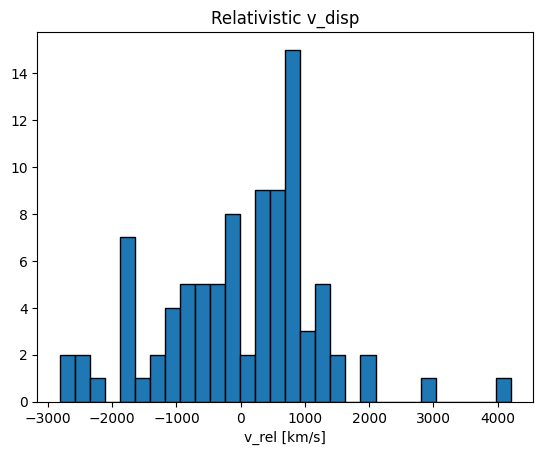

In [19]:
plt.figure();
plt.hist(v_rel.value, bins=30, edgecolor="black")
plt.title("Relativistic v_disp");
plt.xlabel("v_rel [km/s]");
plt.show();

Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



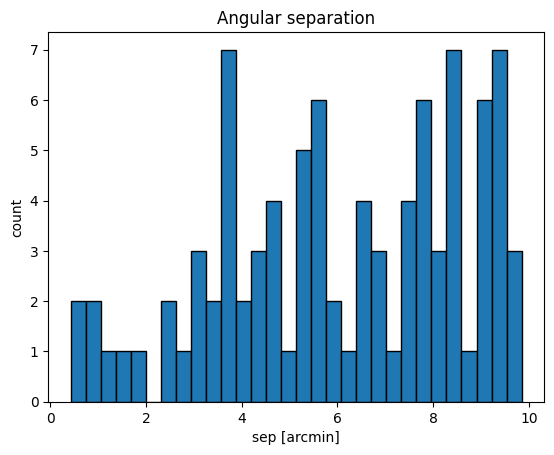

In [20]:
plt.figure();
plt.hist(filtered_df["proj_sep"], bins=30, edgecolor="black");
plt.title("Angular separation");
plt.xlabel("sep [arcmin]");
plt.ylabel("count");
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [21]:
theta       = np.median(filtered_df["proj_sep"]) * u.arcmin
theta_rad   = theta.to(u.rad)

In [22]:
r = (c_kms * z_c / H_0 * (1 - 0.5*z_c*(1+q0))).to(u.Mpc)  # low-z approximation
ra  = (r / (1+z_c)).to(u.Mpc) # angular-diameter

In [23]:
diameter = ra * theta_rad.value

print("Co-moving distance, r =", r)
print("Angular-diameter, ra  =", ra)
print("Cluster diameter      =", diameter)

Co-moving distance, r = 348.15152134598634 Mpc
Angular-diameter, ra  = 322.3422652698339 Mpc
Cluster diameter      = 0.593153720588005 Mpc


### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [33]:
R_m = (0.5 * diameter).to(u.m) # radius in meters
sigma_m = disp.to(u.m/u.s) # σᵥ in m/s

In [34]:
M_dyn = (3 * sigma_m**2 * R_m / G_si).to(u.M_sun)

In [41]:
D_L_pc = cosmo.luminosity_distance(filtered_df["specz"]).to(u.pc).value
m_r    = filtered_df["rmag"].values
M_r    = m_r - 5 * np.log10(D_L_pc/10)   # absolute mag
M_sun  = 4.64  # Sun's r-band M
L_r    = 10**(-0.4 * (M_r - M_sun))
M_L_ratio = 1.0    # assume 1 M☉ per L☉
luminous_mass = L_r * M_L_ratio

In [42]:
cluster_df["luminous_mass"] = luminous_mass
total_luminous_mass = luminous_mass.sum() * u.M_sun

/tmp/ipython-input-42-491636537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df["luminous_mass"] = luminous_mass


In [43]:
print(f"Dynamical mass M_dyn    = {M_dyn.value:.2e} {M_dyn.unit}")
print(f"Total luminous mass     = {total_luminous_mass.value:.2e} {total_luminous_mass.unit}")

Dynamical mass M_dyn    = 3.07e+14 solMass
Total luminous mass     = 2.26e+12 solMass
